# Utilizando un modelo pre-entrenado

[`torchvision.models`](https://pytorch.org/vision/stable/models.html) ofrece una serie de modelos de la literatura de *deep learning* que pueden utilizarse de forma simple. 

Por defecto, cuando se carga un modelo de `models`,  los pesos son aleatorios. Es decir que cargamos una arquitectura que no está entrenada

En cambio si indicamos `pretrained=True` se descarga un modelo entrenado. 

A continuación veremos algunos ejemplos de modelos para clasificar, localizar y segmentar

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Modelo para clasificar imágenes

`torchvision` tiene una basta cantidad de modelos para clasificar incluyendo distintas versiones de VGG, ResNet, AlexNet, GoogLeNet, DenseNet, entre otros

Cargaremos un modelo [resnet18](https://arxiv.org/pdf/1512.03385.pdf) [pre-entrenado](https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.resnet18) en [ImageNet](http://image-net.org/)

In [2]:
from torchvision import models

model = models.resnet18(pretrained=True, progress=True)
model.eval();

Los modelos pre-entrenados esperan imágenes con
- tres canales (RGB)
- al menos 224x224 píxeles
- píxeles entre 0 y 1 (float)
- normalizadas según: 

```python
        normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
```


Sea la siguiente imagen:

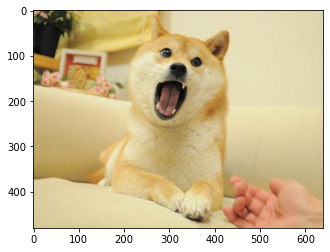

In [3]:
from PIL import Image

img = Image.open("img/dog.jpg")

fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(img);

Si la normalizamos según la transformación anterior se obtiene:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


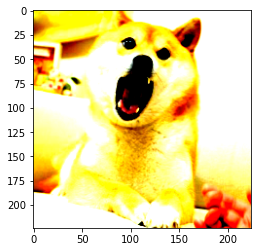

In [4]:
import torch
from torchvision import transforms

TL_transform = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                        std=(0.229, 0.224, 0.225))])
normalized_img = TL_transform(img)

fig, ax = plt.subplots(figsize=(6, 4))

ax.imshow(normalized_img.permute(dims=[1, 2, 0]).detach().numpy());

Luego podemos evaluar el modelo con la nueva imagen:

In [5]:
import torch.nn as nn

probs = nn.Softmax(dim=1)(model.forward(normalized_img.unsqueeze(0)))

El modelo tiene  

In [6]:
len(probs[0, :])

1000

neuronas de salida (clases). Estudiemos las cinco clases más probables según el modelo:

In [7]:
best = probs.argsort(descending=True)
display(best[0, :5], 
        probs[0, best[0, :5]])

tensor([263, 151, 259, 273, 260])

tensor([0.2759, 0.1574, 0.1539, 0.1503, 0.1461], grad_fn=<IndexBackward0>)

¿A qué corresponde estas clases?

Las nombres de las clases de ImageNet son: https://gist.github.com/ageitgey/4e1342c10a71981d0b491e1b8227328b


## Modelo para detectar entidades en imágenes

Adicional a los modelos de clasificación torchvision también tiene modelos para
- Detectar entidades en una imagen: Faster RCNN
- Hacer segmentación por instancia: Mask RCNN
- Hacer segmentación semántica: FCC, DeepLab
- Clasificación de video 

A continuación probaremos la [Faster RCNN](https://arxiv.org/abs/1506.01497) para hace detección. Este modelo fue pre-entrenado en la base de datos [COCO](https://cocodataset.org/)

El modelo retorna un diccionario con:

- 'boxes': Los bounding box de las entidades
- 'labels': La etiqueta de la clase más probable de la entidad
- 'score': La probabilidad de la etiqueta

In [8]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

transform = transforms.ToTensor()
img = Image.open("img/pelea.jpg") # No require normalización de color
img_tensor = transform(img)

result = model(img_tensor.unsqueeze(0))[0]

def filter_results(result, threshold=0.9):
    mask = result['scores'] > threshold
    bbox = result['boxes'][mask].detach().cpu().numpy()
    lbls = result['labels'][mask].detach().cpu().numpy()
    return bbox, lbls

A continuación se muestran algunas de las clases con sus bounding boxes dibujados sobre la imagen original:

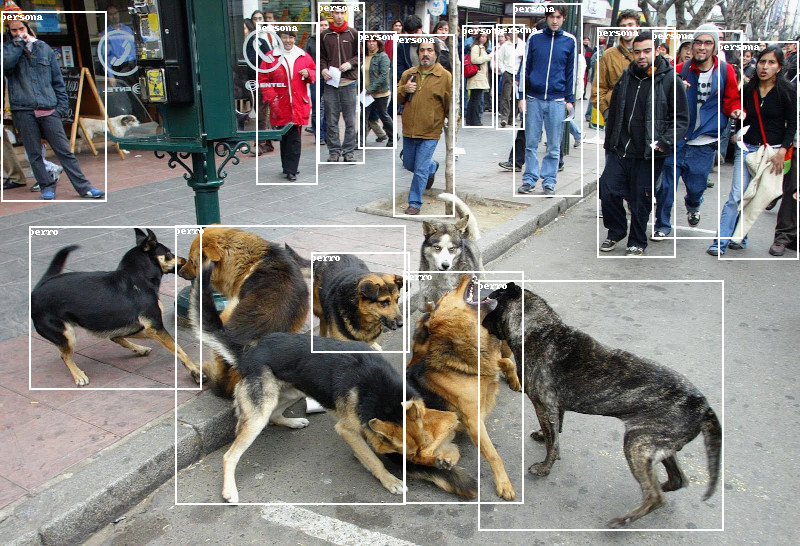

In [9]:
from PIL import ImageFont, ImageDraw
#fnt = ImageFont.truetype("arial.ttf", 20) 

label2name = {1: 'persona', 2: 'bicicleta', 3: 'auto', 4: 'moto', 
              8: 'camioneta', 18: 'perro'}

def draw_rectangles(img, bbox, lbls):
    draw = ImageDraw.Draw(img)
    for k in range(len(bbox)):
        if lbls[k] in label2name.keys():
            draw.rectangle(bbox[k], fill=None, outline='white', width=2)
            draw.text([int(d) for d in bbox[k][:2]], label2name[lbls[k]], fill='white')

bbox, lbls = filter_results(result)
img = Image.open("img/pelea.jpg")
draw_rectangles(img, bbox, lbls)
display(img)

## Transferencia de Aprendizaje


A continuación usaremos la técnicas de transferencia de aprendizaje para aprender un clasificador de imágenes para un fragmento de la base de datos *food 5k*

> El objetivo es clasificar si la imagen corresponde a comida o no

Guardamos las imagenes con la siguiente estructura de carpetas

In [10]:
!ls data/food5k/
!ls data/food5k/train
!ls data/food5k/valid

 train   valid
 food   non_food
 food   non_food


Dada esta estructura podemos usar `torchvision.datasets.ImageFolder` para crear los dataset de forma muy sencilla. 

Como utilizaremos un modelo preentrenado debemos transformar entregar las imágenes en tamaño 224x224 y con color normalizado

Adicionalmente se agrega aumentación de datos en el conjunto de entrenamiento

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


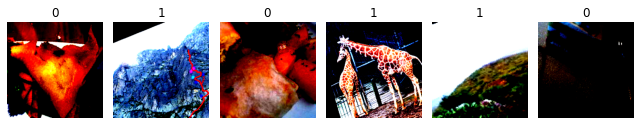

In [11]:
from torchvision import datasets

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder('data/food5k/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder('data/food5k/valid', transform=valid_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)

for image, label in train_loader:
    break
    
fig, ax = plt.subplots(1, 6, figsize=(9, 2), tight_layout=True)
for i in range(6):
    ax[i].imshow(image[i].permute(1,2,0).numpy())
    ax[i].axis('off')
    ax[i].set_title(label[i].numpy())

Usaremos el modelo ResNet18


In [12]:
model = models.resnet18(pretrained=True, progress=True)
# model = models.squeezenet1_1(pretrained=True, progress=True)

Estudiemos la estructura de este modelo:

In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

En este caso re-entrenaremos sólo la última capa, llamada `fc`. Esta es la capa que se encarga de clasificar.

Las demás capas serán congeladas, es decir, no propagaremos gradiente. De esta forma evitamos sobreajustar el modelo con este conjunto de datos pequeño

Para congelar una capa simplemente usamos `requires_grad=False` en sus parámetros. Cuando llamemos `backward` no se calculará gradiente para estas capas

In [14]:
for param in model.parameters(): 
    param.requires_grad = False

Ahora podemos crear una nueva capa de salida que reemplaza a `fc` (por defecto esta tiene `requires_grad=True`)

:::{note}

El problema tiene dos clases, por lo tanto configuramos la capa `fc` con dos neuronas de salida

:::

In [15]:
model.fc = torch.nn.Linear(model.fc.in_features , 2)  # Para resnet

#model.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.5, inplace=False), 
#                                       torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1)),
#                                       torch.nn.ReLU(inplace=True),
#                                       torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))) # Para Squeezenet

Luego entrenamos de forma usual:

In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    epoch_loss, acc = 0.0, 0.0
    for x, y in train_loader:
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        acc += torch.sum(yhat.argmax(dim=1) == y).item()
    epoch_loss /= len(train_loader.dataset)
    acc /= len(train_loader.dataset)
    print(f"Train {epoch}, Loss: {epoch_loss:0.4f}, Acc: {acc:0.3f}")
    
    epoch_loss, acc = 0.0, 0.0
    for x, y in valid_loader:
        yhat = model(x)
        loss = criterion(yhat, y)
        epoch_loss += loss.item()
        acc += torch.sum(yhat.argmax(dim=1) == y).item()
    epoch_loss /= len(valid_loader.dataset)
    acc /= len(valid_loader.dataset)
    print(f"Valid {epoch}, Loss: {epoch_loss:0.4f}, Acc: {acc:0.3f}")
    

Train 0, Loss: 0.0263, Acc: 0.514
Valid 0, Loss: 0.0057, Acc: 0.690
Train 1, Loss: 0.0187, Acc: 0.716
Valid 1, Loss: 0.0039, Acc: 0.880
Train 2, Loss: 0.0137, Acc: 0.856
Valid 2, Loss: 0.0030, Acc: 0.930
Train 3, Loss: 0.0101, Acc: 0.928
Valid 3, Loss: 0.0024, Acc: 0.950
Train 4, Loss: 0.0084, Acc: 0.942
Valid 4, Loss: 0.0020, Acc: 0.980
Train 5, Loss: 0.0081, Acc: 0.923
Valid 5, Loss: 0.0019, Acc: 0.940
Train 6, Loss: 0.0069, Acc: 0.933
Valid 6, Loss: 0.0016, Acc: 0.990
Train 7, Loss: 0.0067, Acc: 0.938
Valid 7, Loss: 0.0015, Acc: 0.980
Train 8, Loss: 0.0081, Acc: 0.918
Valid 8, Loss: 0.0014, Acc: 0.990
Train 9, Loss: 0.0064, Acc: 0.947
Valid 9, Loss: 0.0014, Acc: 0.960


Evaluamos el modelo con:

In [17]:
targets, predictions = [], []
for x, y in valid_loader:
    logits = model(x)
    predictions.append(logits.argmax(dim=1).detach().numpy())
    targets.append(y.numpy())
predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

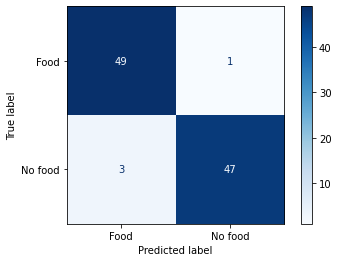

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true=targets, y_pred=predictions, 
                                        display_labels=['Food', 'No food'], cmap=plt.cm.Blues)

**Actividades propuestas**

- Entrenar el modelo anterior con más épocas
- Entrenar el modelo anterior sin pre-entrenamiento
- Entrenar un modelo tipo Lenet5 sobre el dataset anterior
- Comparar los resultados obtenidos entre los distintos modelos:
